# Harmonizing Remote Sensing Data: Multimodal, Multi-Resolution Patch Extraction

## Introduction

In this notebook, we explore a fundamental data processing pipeline for **multimodal remote sensing data**. Our goal is to create **spatially consistent data samples** (patches) across different sensors (e.g., optical, thermal, SAR, DEM) that operate at **different resolutions**.

## Why This Matters

Remote sensing datasets often vary in **spatial resolution** (e.g., 10m, 30m) and **data type** (e.g., multispectral, radar). To integrate these diverse data sources effectively for **machine learning** or **environmental analysis**, we need to:

- **Generate spatially aligned samples** (patches) from all datasets  
- Ensure that these samples represent **the same geographic areas**, even though pixel sizes differ  
- Visualize and understand the **real-world spatial extent** of these patches—because a 224x224 patch in a 10m raster is **physically smaller** than the same-sized patch in a 30m raster!

## What You'll Learn

In this notebook, we'll cover:

- Generating patch center points within a defined boundary (e.g., a watershed)  
- Extracting patches from each dataset that align to these center points  
- Visualizing the **real-world footprint** of these patches across resolutions  
- Understanding how to prepare **multi-resolution, multimodal samples** for downstream ML models

Let’s get started!


In [31]:
%pip install rasterio matplotlib geopandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re
import rasterio
from rasterio.windows import Window
from pyproj import Transformer
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Point

In [ ]:
# Configuration
PATCH_SIZE = 224
STRIDE = 224
PADDING_VALUE = 0
OUTPUT_DIR = './patches'

# Input GeoTIFF paths
raster_paths = {
    'layer0': '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif',
    'elevation': '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif',
    'sar': '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_SAR_VV_10m_Rect.tif',
    'optical': '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Optical_30m_Rect.tif',
    'thermal': '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Thermal_30m_Rect.tif',
}

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [33]:
with rasterio.open(raster_paths['layer0']) as ref_ds:
    print("Layer 0 CRS:", ref_ds.crs)
    print("Layer 0 width x height:", ref_ds.width, ref_ds.height)
    print("Layer 0 transform:", ref_ds.transform)

Layer 0 CRS: EPSG:4269
Layer 0 width x height: 4069 2127
Layer 0 transform: | 0.00, 0.00,-89.46|
| 0.00,-0.00, 40.14|
| 0.00, 0.00, 1.00|


# create valid center points 

In [ ]:
def generate_patch_centers_within_boundary(raster_path, patch_size, stride, boundary_gdf):
    """
    Generate patch centers (lon, lat) within the extent of a boundary GeoJSON polygon.

    Parameters:
        raster_path (str): Path to the raster file.
        patch_size (int): Patch size in pixels.
        stride (int): Stride for patch window movement.
        boundary_gdf (GeoDataFrame): GeoDataFrame containing the boundary polygon (in EPSG:4326).

    Returns:
        GeoDataFrame: Patch centers within the boundary extent (EPSG:4326).
    """
    patch_coords = []

    with rasterio.open(raster_path) as ref_ds:
        # Check CRS and reproject boundary if needed
        if boundary_gdf.crs != ref_ds.crs:
            boundary_gdf = boundary_gdf.to_crs(ref_ds.crs)
        
        # Determine raster extent in the raster's CRS
        raster_bounds = ref_ds.bounds
        raster_extent_poly = gpd.GeoSeries([box(*raster_bounds)], crs=ref_ds.crs)

        # Determine intersection of raster extent and boundary
        boundary_extent = boundary_gdf.total_bounds  # (minx, miny, maxx, maxy)
        minx, miny, maxx, maxy = boundary_extent

        # Generate patch centers within the boundary extent
        for r in range(0, ref_ds.height, stride):
            for c in range(0, ref_ds.width, stride):
                center_r = r + patch_size // 2
                center_c = c + patch_size // 2

                # Convert to geographic coordinates
                lon, lat = ref_ds.xy(center_r, center_c)
                point = Point(lon, lat)

                # Check if point is within the boundary
                if boundary_gdf.unary_union.contains(point):
                    patch_coords.append((lon, lat))

    print(f"✅ Patch centers within boundary: {len(patch_coords)}")
    print("Example center (lon, lat):", patch_coords[0] if patch_coords else "None")

    # Create GeoDataFrame in EPSG:4326
    patch_gdf = gpd.GeoDataFrame({
        'geometry': [Point(lon, lat) for lon, lat in patch_coords]
    }, crs='EPSG:4326')

    return patch_gdf


✅ Patch centers within boundary: 33
Example center (lon, lat): (np.float64(-89.24784805609549), np.float64(40.08987975239339))


/tmp/ipykernel_4080831/2329051774.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if boundary_gdf.unary_union.contains(point):


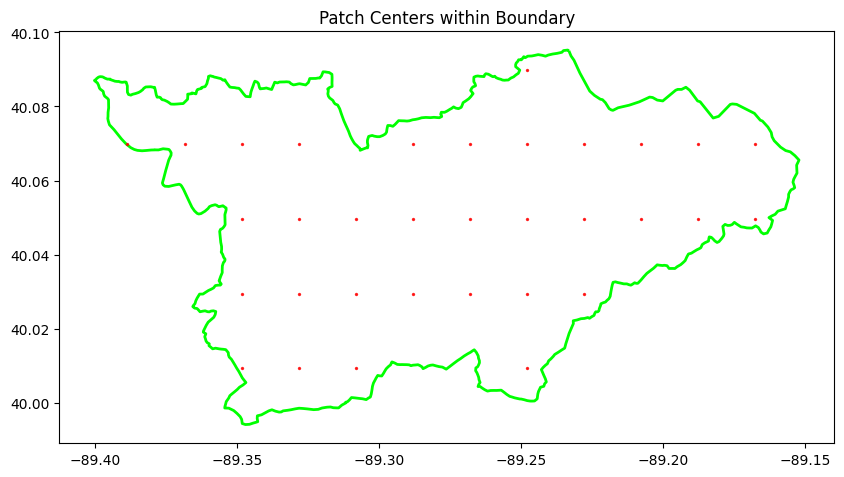

In [45]:
from shapely.geometry import box

# Example usage
raster_path = raster_paths['elevation']
boundary_gdf = gpd.read_file('/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Original_Boundary.geojson')

# Make sure CRS is EPSG:4326
if boundary_gdf.crs is None:
    boundary_gdf.set_crs('EPSG:4326', inplace=True)

patch_centers_gdf = generate_patch_centers_within_boundary(
    raster_path=raster_path,
    patch_size=PATCH_SIZE,
    stride=STRIDE,
    boundary_gdf=boundary_gdf
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
# Plot to confirm
boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=2)
patch_centers_gdf.plot(ax=ax, color='red', markersize=2, alpha=0.8)
plt.title("Patch Centers within Boundary")
plt.show()


In [47]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re

def extract_resolution_from_filename(filename):
    match = re.search(r'_(\d+)(m)_', filename)
    if match:
        return int(match.group(1))
    return None

def visualize_patches_by_resolution(raster_path, patch_centers_gdf, boundary_gdf, patch_size):
    # Extract resolution from filename
    resolution = extract_resolution_from_filename(os.path.basename(raster_path))
    if resolution is None:
        print(f"⚠️ Could not extract resolution from filename: {raster_path}")
        return

    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        data = ds.read(1)  # first band for background
        width, height = ds.width, ds.height

        # Calculate raster extent
        min_lon, max_lat = transform * (0, 0)
        max_lon, min_lat = transform * (width, height)
        extent = (min_lon, max_lon, min_lat, max_lat)

        # Determine patch width & height in degrees
        pixel_size_x, pixel_size_y = transform.a, -transform.e
        patch_width_deg = patch_size * pixel_size_x
        patch_height_deg = patch_size * pixel_size_y

        # Plot
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(data, cmap='gray', alpha=0.7, extent=extent)

        # Plot boundary
        boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=2, alpha=1.0, label='Boundary')

        # Plot patches as rectangles around valid centers
        for pt in patch_centers_gdf.geometry:
            lon, lat = pt.x, pt.y
            rect = Rectangle(
                (lon - patch_width_deg / 2, lat - patch_height_deg / 2),
                patch_width_deg,
                patch_height_deg,
                linewidth=1,
                edgecolor='cyan' if resolution == 5 else
                           'orange' if resolution == 10 else
                           'red' if resolution == 20 else
                           'yellow' if resolution == 30 else
                           'purple',
                facecolor='none',
                alpha=0.6
            )
            ax.add_patch(rect)

        # Plot valid patch centers
        patch_centers_gdf.plot(ax=ax, color='black', markersize=2, alpha=0.8, label='Patch Centers')

        ax.set_title(f"Patches at {resolution}m Resolution (Raster: {os.path.basename(raster_path)})")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend(loc='lower left')
        plt.show()



/tmp/ipykernel_4080831/905167633.py:65: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')


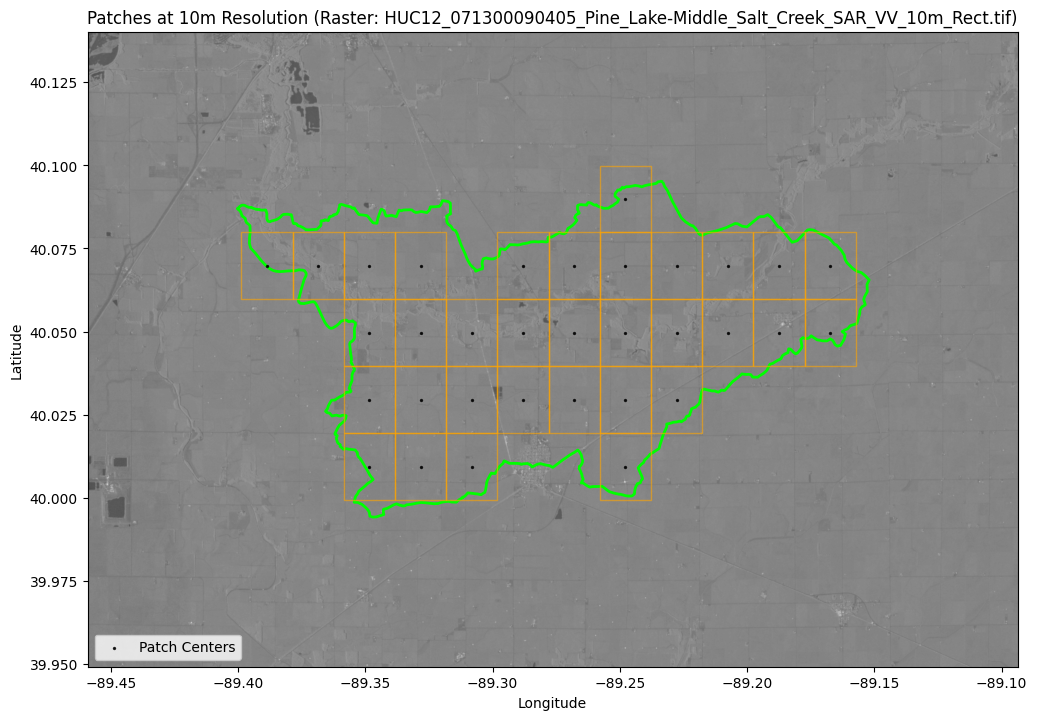

In [49]:
raster_path = raster_paths['sar']
visualize_patches_by_resolution(
    raster_path=raster_path,
    patch_centers_gdf=patch_centers_gdf,
    boundary_gdf=boundary_gdf,
    patch_size=PATCH_SIZE
)

/tmp/ipykernel_4080831/905167633.py:65: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')


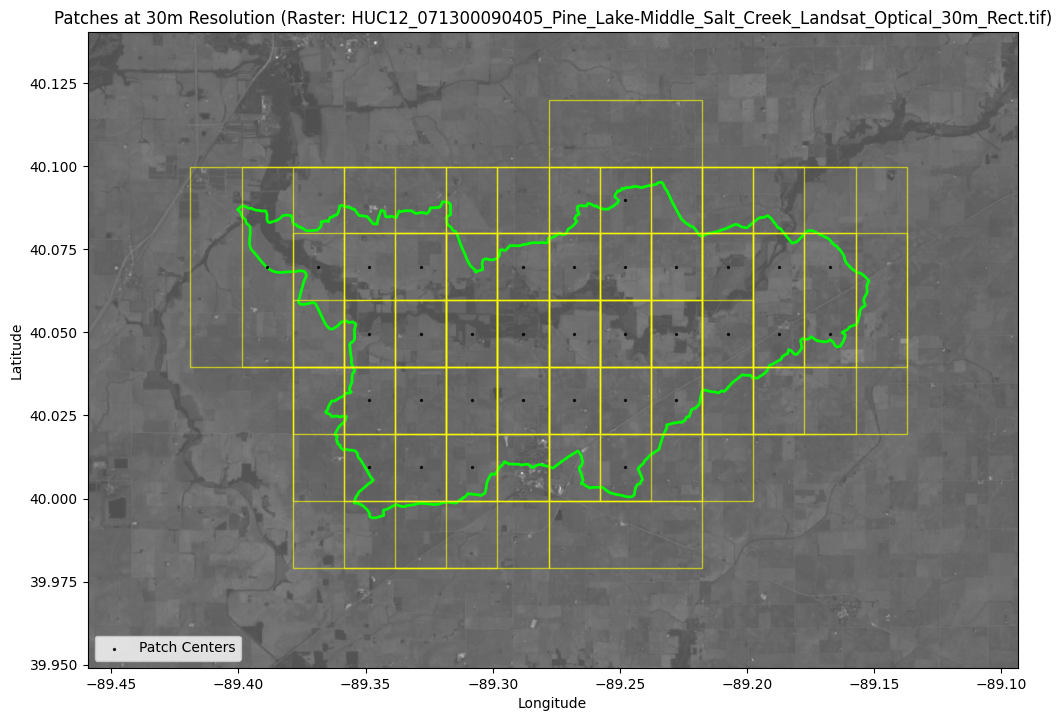

In [50]:
raster_path = raster_paths['optical']
visualize_patches_by_resolution(
    raster_path=raster_path,
    patch_centers_gdf=patch_centers_gdf,
    boundary_gdf=boundary_gdf,
    patch_size=PATCH_SIZE
)

In [56]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
import numpy as np
import re

def extract_resolution_from_filename(filename):
    match = re.search(r'_(\d+)(m)_', filename)
    if match:
        return int(match.group(1))
    return None

def extract_patch_geographic_extent(raster_path, center_point, patch_size, pad_value=0):
    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        width, height = ds.width, ds.height
        crs = ds.crs

        # Convert center point to pixel coordinates
        target_r, target_c = ds.index(center_point.x, center_point.y)

        # Compute top-left window pixel coordinates
        window_r = target_r - patch_size // 2
        window_c = target_c - patch_size // 2
        window = Window(window_c, window_r, patch_size, patch_size)

        # Compute actual window intersection
        full_window = Window(0, 0, width, height)
        actual_window = window.intersection(full_window)

        # Read data for actual window
        data = ds.read(window=actual_window)

        # Pad to desired patch size
        padded_patch = np.full((ds.count, patch_size, patch_size), pad_value, dtype=ds.dtypes[0])
        row_off = max(0, -window_r)
        col_off = max(0, -window_c)
        padded_patch[:, row_off:row_off + actual_window.height, col_off:col_off + actual_window.width] = data

        # Compute geographic extent of the patch
        min_lon, max_lat = transform * (window_c, window_r)
        max_lon, min_lat = transform * (window_c + patch_size, window_r + patch_size)
        extent = (min_lon, max_lon, min_lat, max_lat)

        return padded_patch, extent, crs

def visualize_patch0_extent_side_by_side(raster_paths, valid_centers_gdf, patch_size, pad_value=0):
    fig, axes = plt.subplots(1, len(raster_paths), figsize=(5 * len(raster_paths), 6), constrained_layout=True)

    if len(raster_paths) == 1:
        axes = [axes]

    for ax, raster_path in zip(axes, raster_paths):
        resolution = extract_resolution_from_filename(raster_path)
        if resolution is None:
            resolution = 'Unknown'

        # Use the first valid center point
        center_point = valid_centers_gdf.geometry.iloc[0]

        patch_data, extent, crs = extract_patch_geographic_extent(
            raster_path, center_point, patch_size, pad_value
        )

        # Plot the patch
        if patch_data.shape[0] == 1:
            ax.imshow(patch_data[0], cmap='gray', alpha=0.7, extent=extent)
        else:
            ax.imshow(np.transpose(patch_data[:3], (1, 2, 0)), alpha=0.7, extent=extent)

        ax.set_title(f"{os.path.basename(raster_path)}\nResolution: {resolution}m\nExtent: {np.round(extent, 4)}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    plt.suptitle("Patch 0 from Each Raster (Spatial Extent)", fontsize=16)
    plt.show()


def visualize_patch0_same_scale(raster_paths, valid_centers_gdf, patch_size, pad_value=0):
    # Store patches and their extents
    patches_data = []
    all_extents = []

    for raster_path in raster_paths:
        center_point = valid_centers_gdf.geometry.iloc[0]
        patch_data, extent, crs = extract_patch_geographic_extent(
            raster_path, center_point, patch_size, pad_value
        )
        patches_data.append((patch_data, raster_path))
        all_extents.append(extent)

    # Determine the overall extent for all plots
    min_lon = min(ext[0] for ext in all_extents)
    max_lon = max(ext[1] for ext in all_extents)
    min_lat = min(ext[2] for ext in all_extents)
    max_lat = max(ext[3] for ext in all_extents)
    overall_extent = (min_lon, max_lon, min_lat, max_lat)

    print("✅ Overall extent for visualization:", np.round(overall_extent, 4))

    # Plot all patches side by side with the same scale (extent)
    fig, axes = plt.subplots(1, len(raster_paths), figsize=(5 * len(raster_paths), 6), constrained_layout=True)

    if len(raster_paths) == 1:
        axes = [axes]

    for ax, (patch_data, raster_path) in zip(axes, patches_data):
        resolution = extract_resolution_from_filename(raster_path) or 'Unknown'
        if patch_data.shape[0] == 1:
            ax.imshow(patch_data[0], cmap='gray', alpha=0.7, extent=overall_extent)
        else:
            ax.imshow(np.transpose(patch_data[:3], (1, 2, 0)), alpha=0.7, extent=overall_extent)

        ax.set_title(f"{os.path.basename(raster_path)}\nResolution: {resolution}m")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    plt.suptitle("Patch 0 from Each Raster (Same Scale / Spatial Extent)", fontsize=16)
    plt.show()


def visualize_patches_real_world_extent(raster_paths, patch_centers_gdf, patch_size):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the boundary polygon
    gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=2, alpha=1.0, label='Boundary')

    for raster_path in raster_paths:
        resolution = extract_resolution_from_filename(raster_path)
        if resolution is None:
            resolution = 10  # default if resolution not in filename

        # Use the first valid center point
        center_point = patch_centers_gdf.geometry.iloc[0]
        lon, lat = center_point.x, center_point.y

        # Convert center point to UTM for accurate meter-based sizes
        transformer_to_utm = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
        utm_x, utm_y = transformer_to_utm.transform(lon, lat)

        # Calculate patch extent in UTM coordinates (in meters)
        patch_half_size_m = (patch_size * resolution) / 2
        min_x = utm_x - patch_half_size_m
        max_x = utm_x + patch_half_size_m
        min_y = utm_y - patch_half_size_m
        max_y = utm_y + patch_half_size_m

        # Convert patch extent back to lon/lat for plotting
        transformer_to_latlon = Transformer.from_crs("EPSG:32616", "EPSG:4326", always_xy=True)
        min_lon, min_lat = transformer_to_latlon.transform(min_x, min_y)
        max_lon, max_lat = transformer_to_latlon.transform(max_x, max_y)

        # Create polygon (as a box) for the patch extent
        patch_box = box(min_lon, min_lat, max_lon, max_lat)
        patch_gdf = gpd.GeoDataFrame({'geometry': [patch_box]}, crs='EPSG:4326')

        # Plot patch box
        color = 'cyan' if resolution == 5 else \
                'orange' if resolution == 10 else \
                'red' if resolution == 20 else \
                'yellow' if resolution == 30 else 'purple'
        patch_gdf.plot(ax=ax, facecolor='none', edgecolor=color, linewidth=2,
                        alpha=0.7, label=f'Patch {resolution}m')

    ax.set_title("Real-World Patch Extents (Accurate Footprints)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='lower left')
    plt.show()

✅ Overall extent for visualization: [-89.2782 -89.2178  40.0598  40.1202]


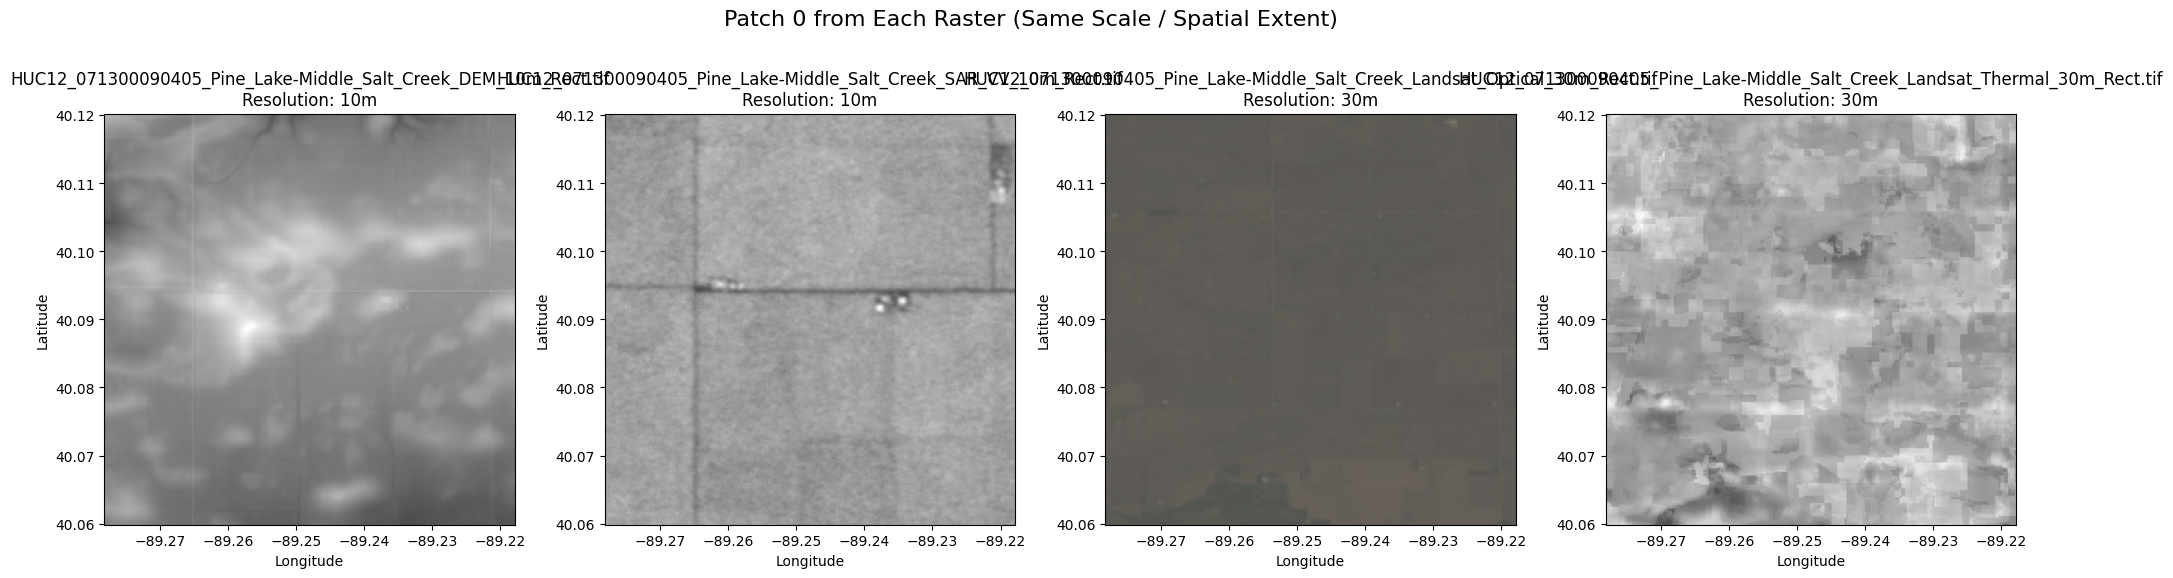

In [55]:
# Example list of raster file paths (update to your raster paths!)
raster_files = [
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_SAR_VV_10m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Optical_30m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Thermal_30m_Rect.tif',
]

# Visualize patch 0 from each raster side by side
visualize_patch0_same_scale(raster_files, patch_centers_gdf, PATCH_SIZE)

In [58]:
import rasterio
from pyproj import Transformer
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np
import re
import os

def extract_resolution_from_filename(filename):
    match = re.search(r'_(\d+)(m)_', filename)
    if match:
        return int(match.group(1))
    return None

def extract_patch_data_and_extent(raster_path, center_point, patch_size, pad_value=0):
    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        width, height = ds.width, ds.height

        # Convert center point to pixel coordinates
        target_r, target_c = ds.index(center_point.x, center_point.y)

        # Calculate window
        window_r = target_r - patch_size // 2
        window_c = target_c - patch_size // 2
        window = rasterio.windows.Window(window_c, window_r, patch_size, patch_size)

        # Compute actual intersection window
        full_window = rasterio.windows.Window(0, 0, width, height)
        actual_window = window.intersection(full_window)

        # Read data
        data = ds.read(window=actual_window)

        # Pad data if needed
        padded_patch = np.full((ds.count, patch_size, patch_size), pad_value, dtype=ds.dtypes[0])
        row_off = max(0, -window_r)
        col_off = max(0, -window_c)
        padded_patch[:, row_off:row_off + actual_window.height, col_off:col_off + actual_window.width] = data

        # Calculate real-world extent (lon/lat)
        min_lon, max_lat = transform * (window_c, window_r)
        max_lon, min_lat = transform * (window_c + patch_size, window_r + patch_size)
        extent = (min_lon, max_lon, min_lat, max_lat)

        return padded_patch, extent

def visualize_real_world_patch_data(raster_paths, patch_centers_gdf, patch_size, pad_value=0):
    fig, axes = plt.subplots(1, len(raster_paths), figsize=(6 * len(raster_paths), 6), constrained_layout=True)

    if len(raster_paths) == 1:
        axes = [axes]

    # Load the boundary polygon
    geojson_path = '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Original_Boundary.geojson'
    gdf = gpd.read_file(geojson_path)
    if gdf.crs is None:
        gdf.set_crs('EPSG:4326', inplace=True)

    for ax, raster_path in zip(axes, raster_paths):
        resolution = extract_resolution_from_filename(raster_path)
        if resolution is None:
            resolution = 10

        # Use first valid center point
        center_point = patch_centers_gdf.geometry.iloc[0]
        lon, lat = center_point.x, center_point.y

        # Extract patch data and geographic extent
        patch_data, extent = extract_patch_data_and_extent(
            raster_path, center_point, patch_size, pad_value
        )

        # Plot the patch data in real-world extent
        if patch_data.shape[0] == 1:
            ax.imshow(patch_data[0], cmap='gray', extent=extent, alpha=0.7)
        else:
            ax.imshow(np.transpose(patch_data[:3], (1, 2, 0)), extent=extent, alpha=0.7)

        # Plot the boundary for context
        gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=2, alpha=1.0, label='Boundary')

        # Plot patch center
        ax.scatter(lon, lat, color='red', s=20, label='Patch Center')

        ax.set_title(f"{os.path.basename(raster_path)}\nResolution: {resolution}m\nExtent: {np.round(extent, 5)}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend(loc='lower left')

    plt.suptitle("Real-World Spatial Extent of Patch 0 Data (Aligned Footprint)", fontsize=16)
    plt.show()


/tmp/ipykernel_4080831/2237733854.py:90: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')
/tmp/ipykernel_4080831/2237733854.py:90: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')
/tmp/ipykernel_4080831/2237733854.py:90: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')
/tmp/ipykernel_4080831/2237733854.py:90: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legen

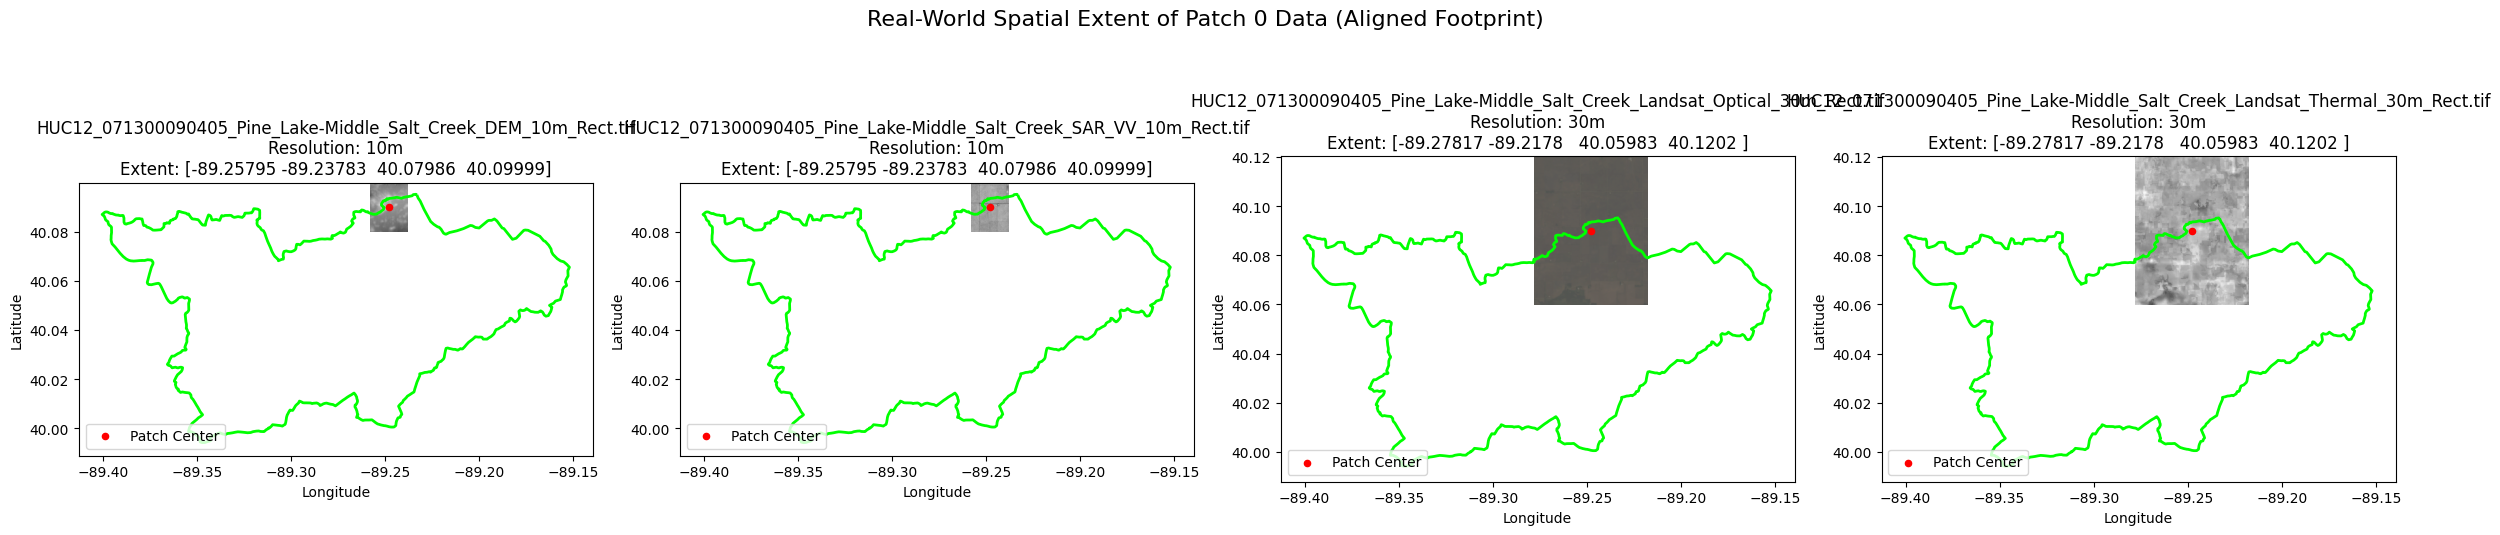

In [59]:
# Example list of raster file paths (update to your raster paths!)
raster_files = [
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_SAR_VV_10m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Optical_30m_Rect.tif',
    '/u/nathanj/national_ml/data/HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Thermal_30m_Rect.tif',
]

# Visualize patch 0 from each raster side by side
visualize_real_world_patch_data(raster_files, patch_centers_gdf, PATCH_SIZE)